# HEALTHCARE FRAUD DETECTION
The objective of this project is to predict fraudulent claims submitted by patients. The dataset has been acquired from Kaggle. The original problem required us to find fraudulent claims submitted by Providers like hospitals, medical institutions. But I choose to focus on predicting fraudulent claims submitted by patients since I believe it will be of better use to the insurance companies.

In [76]:
import pandas as pd
import numpy as np
import matplotlib as mpl

In [77]:
import seaborn as sns

In [78]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV # for memory and time efficient hyperparameter tuning, approximate best hypetparameters
import xgboost as xgb
import lightgbm as lgb

In [ ]:
# Reading train datasets which includes following files:
# Train_beneficiary - It has data related to all the beneficiaries/patients who have filed the claims
# Train_InPatient - It has data related to details of the claim filed by the patients who were admitted to the hospital.
# Train_OutPatient - It has data related to details of the claim filed by the patients who were NOT admitted to the hospital.
# Train_file - Consists information of the provider

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
Train_bene = pd.read_csv("./Healthcare_Fraud_Detection/Train_Beneficiarydata-1542865627584.csv")
Train_bene.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,2,2,2,2,2,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,1,2,2,2,2,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,1,1,2,2,2,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,2,2,2,2,1,2,1,2,2,2,2,0,0,1790,1200


In [ ]:
# The data set more than 1.3 lakh rows and 25 features and all the values are unique

In [6]:
len(Train_bene['BeneID'].unique())

138556

In [7]:
#Beneficiary ID is primary key for train_bene table

In [8]:
Train_bene.dtypes
Train_bene.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   BeneID                           138556 non-null  object
 1   DOB                              138556 non-null  object
 2   DOD                              1421 non-null    object
 3   Gender                           138556 non-null  int64 
 4   Race                             138556 non-null  int64 
 5   RenalDiseaseIndicator            138556 non-null  object
 6   State                            138556 non-null  int64 
 7   County                           138556 non-null  int64 
 8   NoOfMonths_PartACov              138556 non-null  int64 
 9   NoOfMonths_PartBCov              138556 non-null  int64 
 10  ChronicCond_Alzheimer            138556 non-null  int64 
 11  ChronicCond_Heartfailure         138556 non-null  int64 
 12  ChronicCond_Kidn

In [9]:
Train_bene.isnull().sum()

BeneID                                  0
DOB                                     0
DOD                                137135
Gender                                  0
Race                                    0
RenalDiseaseIndicator                   0
State                                   0
County                                  0
NoOfMonths_PartACov                     0
NoOfMonths_PartBCov                     0
ChronicCond_Alzheimer                   0
ChronicCond_Heartfailure                0
ChronicCond_KidneyDisease               0
ChronicCond_Cancer                      0
ChronicCond_ObstrPulmonary              0
ChronicCond_Depression                  0
ChronicCond_Diabetes                    0
ChronicCond_IschemicHeart               0
ChronicCond_Osteoporasis                0
ChronicCond_rheumatoidarthritis         0
ChronicCond_stroke                      0
IPAnnualReimbursementAmt                0
IPAnnualDeductibleAmt                   0
OPAnnualReimbursementAmt          

In [ ]:
# Only Date Of Death (DOD) feature has null values and most of the features are numerical features

In [10]:
Train_Inpatient = pd.read_csv("./Healthcare_Fraud_Detection/Train_Inpatientdata-1542865627584.csv")
Train_Inpatient.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# The Provider and ClaimID have unique values for each record 

In [11]:
Train_Inpatient.duplicated().sum()

0

In [12]:
Train_Inpatient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40474 entries, 0 to 40473
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BeneID                  40474 non-null  object 
 1   ClaimID                 40474 non-null  object 
 2   ClaimStartDt            40474 non-null  object 
 3   ClaimEndDt              40474 non-null  object 
 4   Provider                40474 non-null  object 
 5   InscClaimAmtReimbursed  40474 non-null  int64  
 6   AttendingPhysician      40362 non-null  object 
 7   OperatingPhysician      23830 non-null  object 
 8   OtherPhysician          4690 non-null   object 
 9   AdmissionDt             40474 non-null  object 
 10  ClmAdmitDiagnosisCode   40474 non-null  object 
 11  DeductibleAmtPaid       39575 non-null  float64
 12  DischargeDt             40474 non-null  object 
 13  DiagnosisGroupCode      40474 non-null  object 
 14  ClmDiagnosisCode_1      40474 non-null

In [13]:
Train_Outpatient = pd.read_csv("./Healthcare_Fraud_Detection/Train_Outpatientdata-1542865627584.csv")
Train_Outpatient.head()


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,V5866,V1272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,30000,72887,4280,7197,V4577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [14]:
Train_Outpatient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517737 entries, 0 to 517736
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   BeneID                  517737 non-null  object 
 1   ClaimID                 517737 non-null  object 
 2   ClaimStartDt            517737 non-null  object 
 3   ClaimEndDt              517737 non-null  object 
 4   Provider                517737 non-null  object 
 5   InscClaimAmtReimbursed  517737 non-null  int64  
 6   AttendingPhysician      516341 non-null  object 
 7   OperatingPhysician      90617 non-null   object 
 8   OtherPhysician          195046 non-null  object 
 9   ClmDiagnosisCode_1      507284 non-null  object 
 10  ClmDiagnosisCode_2      322357 non-null  object 
 11  ClmDiagnosisCode_3      203257 non-null  object 
 12  ClmDiagnosisCode_4      125596 non-null  object 
 13  ClmDiagnosisCode_5      74344 non-null   object 
 14  ClmDiagnosisCode_6  

In [15]:
Train_Outpatient.duplicated().sum()

0

In [16]:
Train_file = pd.read_csv("./Healthcare_Fraud_Detection/Train-1542865627584.csv")
Train_file.head()

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


In [17]:
Train_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Provider        5410 non-null   object
 1   PotentialFraud  5410 non-null   object
dtypes: object(2)
memory usage: 84.7+ KB


In [ ]:
# Adding a new column in In-patient dataset and initializing the column with 1 which will be used to identify the record 
# as In-patient beneficiary after merging all the tables

In [18]:
Train_Inpatient['In/Op'] = 1

In [19]:
Train_Inpatient.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Op
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1


In [20]:
Train_Outpatient['In/Op'] = 0

In [ ]:
# Adding a new column in Out-patient dataset and initializing the column with 0 which will be used to identify the record 
# as Out-patient beneficiary after merging all the tables

In [21]:
Train_Outpatient['Provider'].duplicated().sum()
#Train_Outpatient.head()

512725

In [ ]:
# Creating new dataset InP_OutP_train by concatenating two datasets - InPatients and OutPatients 
# which have no duplicate records in them

In [22]:
InP_OutP_train = pd.concat([Train_Inpatient, Train_Outpatient])
InP_OutP_train.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Op
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
# Merged two files InP_OutP_train concatenated file with the Train_beneficiary file on "BeneID" 
# since it is the primary key in Train_bene table


# Merged this file obtained with the Train_file on "Provider" since it is the primary key in Train_file table

In [23]:
train_InP_OutP_merged = pd.merge(InP_OutP_train, Train_bene, on="BeneID", how="inner")
train_final_merged = pd.merge(train_InP_OutP_merged, Train_file, on="Provider", how="inner" )
train_final_merged.head()


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Op,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,Yes
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,No
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,No
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1,1914-03-01,NaN,2,2,0,1,360,12,12,2,1,1,2,2,1,1,2,2,1,1,5000,1068,250,320,No
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1,1938-04-01,NaN,2,1,Y,45,780,12,12,2,1,1,2,1,1,2,1,2,2,2,21260,2136,120,100,No


In [24]:
train_final_merged = train_final_merged.reset_index(drop=True)

In [ ]:
# Checking for duplicates in the final merged file

In [25]:
train_final_merged.duplicated().sum()

0

In [ ]:
# Checking dimesions in the final merged file

In [26]:
train_final_merged.shape

(558211, 56)

In [27]:
train_final_merged.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'In/Op', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'C

In [ ]:
# Since all the columns with date are of object data-type, we need to convert them to date format
# Calculated the no. of days InPatient was admitted to the hospital (Adding +1 so the admitted day is counted as well)
# Since only InPatient beneficiaries were admitted to the hospital, assigning 0 for the OutPatient beneficiary records 
# as they were not admitted to the hospital

In [28]:
train_final_merged['AdmissionDt'] = pd.to_datetime(train_final_merged['AdmissionDt'] , format = '%Y-%m-%d')
train_final_merged['DischargeDt'] = pd.to_datetime(train_final_merged['DischargeDt'],format = '%Y-%m-%d')
train_final_merged['DaysAdmittedInP'] = ((train_final_merged['DischargeDt'] - train_final_merged['AdmissionDt']).dt.days)+1
train_final_merged['DaysAdmittedInP'] = train_final_merged['DaysAdmittedInP'].fillna(0)
train_final_merged.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Op,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,DaysAdmittedInP
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,Yes,7.0
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,No,3.0
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,No,4.0
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1,1914-03-01,NaN,2,2,0,1,360,12,12,2,1,1,2,2,1,1,2,2,1,1,5000,1068,250,320,No,9.0
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1,1938-04-01,NaN,2,1,Y,45,780,12,12,2,1,1,2,1,1,2,1,2,2,2,21260,2136,120,100,No,18.0


In [ ]:
# Again converting the CLaimStart and ClaimEnd date to appropriate format
#Calculating the period of days for which the claim for medical expenses were made
#We will be dropping the columns with date and time stamp in the following steps as they do not provide any learning to model

In [29]:
train_final_merged['ClaimStartDt'] = pd.to_datetime(train_final_merged['ClaimStartDt'] , format = '%Y-%m-%d')
train_final_merged['ClaimEndDt'] = pd.to_datetime(train_final_merged['ClaimEndDt'],format = '%Y-%m-%d')
train_final_merged['ClaimPeriod'] = ((train_final_merged['ClaimEndDt'] - train_final_merged['ClaimStartDt']).dt.days)+1
train_final_merged.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Op,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,DaysAdmittedInP,ClaimPeriod
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,Yes,7.0,7
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,No,3.0,3
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,No,4.0,4
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1,1914-03-01,NaN,2,2,0,1,360,12,12,2,1,1,2,2,1,1,2,2,1,1,5000,1068,250,320,No,9.0,9
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1,1938-04-01,NaN,2,1,Y,45,780,12,12,2,1,1,2,1,1,2,1,2,2,2,21260,2136,120,100,No,18.0,18


In [ ]:
#Similarly converted the format of the Date_of_Birth and Date_of_Death
# Calculating and creating a new feature Age of the beneficiaries by substracting date of birth from date of death
# The maximum date of death is 1st december 2009, hence subtracting the date of birth from it to replace the NA values.

In [30]:
train_final_merged['DOB'] = pd.to_datetime(train_final_merged['DOB'] , format = '%Y-%m-%d')
train_final_merged['DOD'] = pd.to_datetime(train_final_merged['DOD'],format = '%Y-%m-%d',errors='ignore')
train_final_merged['Age'] = round(((train_final_merged['DOD'] - train_final_merged['DOB']).dt.days)/365)

# 
train_final_merged.Age.fillna(round(((pd.to_datetime('2009-12-01' , format = '%Y-%m-%d') - train_final_merged['DOB']).dt.days)/365), inplace=True)

C:\Users\shlok\AppData\Local\Temp\ipykernel_26652\3874005665.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  train_final_merged['DOD'] = pd.to_datetime(train_final_merged['DOD'],format = '%Y-%m-%d',errors='ignore')
C:\Users\shlok\AppData\Local\Temp\ipykernel_26652\3874005665.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_final_merged.Age.fillna(round(((pd.to_datetime('2009-12-01' , format = '%Y-%

C:\Users\shlok\anaconda3\envs\Shlokaenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


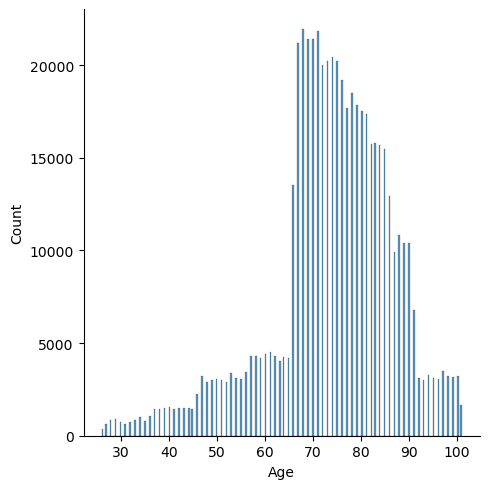

In [31]:
sns.displot(train_final_merged['Age'])

In [32]:
train_final_merged['ClaimID'].duplicated().sum()

0

## Convert columns to string

In [ ]:
#Creating a list of all the Claim Procedure and Diagnosis Codes so as to easily iterate and manipulate the values

In [33]:
ClmProcedureCode = ['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3','ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6',]
ClmDiagnosisCode = ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7','ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', "ClmAdmitDiagnosisCode", "DiagnosisGroupCode"]

In [34]:
train_final_merged[ClmDiagnosisCode[0]].dtype

dtype('O')

In [ ]:
# Converting the variables of object datatype to string format so as to encode the categorical variables into numerical format 
# using One-hot Encoding technique

In [35]:
for D_code in ClmDiagnosisCode:
    if train_final_merged[D_code].dtype != "O":
        train_final_merged[D_code] = train_final_merged[D_code].astype(int)
    train_final_merged[D_code] = train_final_merged[D_code].astype(str).str[:1]

In [36]:
for P_code in ClmProcedureCode:
    train_final_merged[P_code].fillna('-1',inplace=True)
    train_final_merged[P_code] = train_final_merged[P_code].astype(int)
    train_final_merged[P_code] = train_final_merged[P_code].astype(str).str[:1]

C:\Users\shlok\AppData\Local\Temp\ipykernel_26652\2011249827.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_final_merged[P_code].fillna('-1',inplace=True)
C:\Users\shlok\AppData\Local\Temp\ipykernel_26652\2011249827.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train_final_merged[P_code].fillna('-1',inplace=True)
C:\Users\shlok\AppData

In [37]:
train_final_merged['Race'].unique()

array([1, 2, 3, 5], dtype=int64)

In [38]:
len(train_final_merged['State'].unique())

52

In [39]:
len(train_final_merged['County'].unique())

314

In [40]:
train_final_merged['Gender'].unique()

array([1, 2], dtype=int64)

In [41]:
train_final_merged['Gender'] -= 1

In [ ]:
# RenalDiseaseIndicator has two levels '0' and 'Y', hence replcaing the categorical value with integer 
# and converting it to numeric data-type

In [42]:
train_final_merged['RenalDiseaseIndicator'].unique()

array(['0', 'Y'], dtype=object)

In [43]:
train_final_merged['RenalDiseaseIndicator'].replace('Y','1',inplace=True)
train_final_merged['RenalDiseaseIndicator'] = train_final_merged['RenalDiseaseIndicator'].astype(int)
train_final_merged['RenalDiseaseIndicator'].unique()

C:\Users\shlok\AppData\Local\Temp\ipykernel_26652\2597195434.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_final_merged['RenalDiseaseIndicator'].replace('Y','1',inplace=True)


array([0, 1])

In [ ]:
# Creating list of various chronic conditions expereinced by patients

In [44]:
Chronic_Conds = ['ChronicCond_Alzheimer','ChronicCond_Heartfailure','ChronicCond_KidneyDisease','ChronicCond_Cancer','ChronicCond_ObstrPulmonary','ChronicCond_Depression','ChronicCond_Diabetes','ChronicCond_IschemicHeart','ChronicCond_Osteoporasis','ChronicCond_rheumatoidarthritis','ChronicCond_stroke']

In [ ]:
#Since each variable has two levels 1 & 2 converting them to 0 and 1 numeric values for convenience

In [45]:
for c in Chronic_Conds:
    train_final_merged[c] = train_final_merged[c] -1

In [ ]:
#Creating a new feature 'has_Chronic' to easily identify if the patient has any chronic condition or not

In [46]:
train_final_merged['has_Chronic'] =0
for c in Chronic_Conds:
    train_final_merged['has_Chronic'] = train_final_merged['has_Chronic'] + train_final_merged[c]
train_final_merged["has_Chronic"] = (train_final_merged["has_Chronic"] > 0).astype(int)

In [47]:
train_final_merged["has_Chronic"].value_counts()

has_Chronic
1    557749
0       462
Name: count, dtype: int64

In [48]:
train_final_merged.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Op,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,DaysAdmittedInP,ClaimPeriod,Age,has_Chronic
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7,1068.0,2009-04-18,2,1,4,5,7,2,7,2,1,5,n,-,-,-,-,-,-,1,1943-01-01,NaT,0,1,0,39,230,12,12,0,1,0,1,1,0,0,0,1,0,0,36000,3204,60,70,Yes,7.0,7,67.0,1
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6,1068.0,2009-09-02,7,6,2,5,n,n,n,n,n,n,n,7,-,-,-,-,-,1,1943-01-01,NaT,0,1,0,39,230,12,12,0,1,0,1,1,0,0,0,1,0,0,36000,3204,60,70,No,3.0,3,67.0,1
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,2,1068.0,2009-09-20,8,2,3,7,3,V,3,n,n,n,n,-,-,-,-,-,-,1,1943-01-01,NaT,0,1,0,39,230,12,12,0,1,0,1,1,0,0,0,1,0,0,36000,3204,60,70,No,4.0,4,67.0,1
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,4,1068.0,2009-02-22,0,4,2,7,3,V,4,2,4,4,n,3,-,-,-,-,-,1,1914-03-01,NaT,1,2,0,1,360,12,12,1,0,0,1,1,0,0,1,1,0,0,5000,1068,250,320,No,9.0,9,96.0,1
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,7,1068.0,2009-08-30,9,0,3,3,5,4,4,5,2,2,n,3,-,-,-,-,-,1,1938-04-01,NaT,1,1,1,45,780,12,12,1,0,0,1,0,0,1,0,1,1,1,21260,2136,120,100,No,18.0,18,72.0,1


In [79]:
train_final_merged.loc[train_final_merged.DOD.isna(),'Expired']=0
train_final_merged.loc[train_final_merged.DOD.notna(),'Expired']=1

In [80]:
train_final_merged.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,In/Op,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,DaysAdmittedInP,ClaimPeriod,Age,has_Chronic,Expired
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7,1068.0,2009-04-18,2,1,4,5,7,2,7,2,1,5,n,-,-,-,-,-,-,1,1943-01-01,NaT,0,1,0,39,230,12,12,0,1,0,1,1,0,0,0,1,0,0,36000,3204,60,70,Yes,7.0,7,67.0,1,0.0
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6,1068.0,2009-09-02,7,6,2,5,n,n,n,n,n,n,n,7,-,-,-,-,-,1,1943-01-01,NaT,0,1,0,39,230,12,12,0,1,0,1,1,0,0,0,1,0,0,36000,3204,60,70,No,3.0,3,67.0,1,0.0
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,2,1068.0,2009-09-20,8,2,3,7,3,V,3,n,n,n,n,-,-,-,-,-,-,1,1943-01-01,NaT,0,1,0,39,230,12,12,0,1,0,1,1,0,0,0,1,0,0,36000,3204,60,70,No,4.0,4,67.0,1,0.0
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,4,1068.0,2009-02-22,0,4,2,7,3,V,4,2,4,4,n,3,-,-,-,-,-,1,1914-03-01,NaT,1,2,0,1,360,12,12,1,0,0,1,1,0,0,1,1,0,0,5000,1068,250,320,No,9.0,9,96.0,1,0.0
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,7,1068.0,2009-08-30,9,0,3,3,5,4,4,5,2,2,n,3,-,-,-,-,-,1,1938-04-01,NaT,1,1,1,45,780,12,12,1,0,0,1,0,0,1,0,1,1,1,21260,2136,120,100,No,18.0,18,72.0,1,0.0


# Data preprocessing and encoding

In [50]:
cols_to_drop = ['BeneID','ClaimID','ClaimStartDt','ClaimEndDt','Provider','AdmissionDt','DischargeDt','DOB', 'DOD','AttendingPhysician','OperatingPhysician','OtherPhysician', 'ClmDiagnosisCode_4','ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7','ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6']
target = "PotentialFraud"

In [51]:
encoding_list = []
for i in train_final_merged.columns:
    if train_final_merged[i].dtype == "O":
        if i not in cols_to_drop+[target]:
            encoding_list.append(i)

print(encoding_list)

['ClmAdmitDiagnosisCode', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3']


In [52]:
for i in encoding_list:
    print(i, str(len(train_final_merged[i].unique())))

ClmAdmitDiagnosisCode 13
DiagnosisGroupCode 12
ClmDiagnosisCode_1 13
ClmDiagnosisCode_2 13
ClmDiagnosisCode_3 13
ClmProcedureCode_1 10
ClmProcedureCode_2 10
ClmProcedureCode_3 10


## Train-Test split

In [53]:
X = train_final_merged.drop(columns = ["PotentialFraud"])
y = train_final_merged["PotentialFraud"]

In [54]:
# Assuming X contains the features and y contains the target variable
# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### One Hot Encoding

In [55]:
# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit and transform the categorical columns
one_hot_encoder.fit(X_train[encoding_list])
one_hot_encoded = one_hot_encoder.transform(X_train[encoding_list])

feature_names = one_hot_encoder.get_feature_names_out(input_features=encoding_list)

# Convert the transformed data to a DataFrame with appropriate column names
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=feature_names)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
X_train_final = pd.concat([X_train.drop(columns=encoding_list), one_hot_encoded_df], axis=1)


C:\Users\shlok\anaconda3\envs\Shlokaenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [56]:
X_train_final = X_train_final.drop(columns=cols_to_drop)
X_train_final.shape

(446568, 124)

In [ ]:
(446568, 124)

In [57]:
mapping_dict = {'Yes': 1, 'No': 0}

# Map values in the DataFrame column using the mapping dictionary
y_train = y_train.map(mapping_dict)

In [58]:
y_train.value_counts()

PotentialFraud
0    276432
1    170136
Name: count, dtype: int64

### Same on Test

In [59]:
# Encoding is done using the same onehot object trained on the Training data

In [60]:
# Transform the categorical columns
one_hot_encoded = one_hot_encoder.transform(X_test[encoding_list])

feature_names = one_hot_encoder.get_feature_names_out(input_features=encoding_list)

# Convert the transformed data to a DataFrame with appropriate column names
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=feature_names)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
X_test_final = pd.concat([X_test.drop(columns=encoding_list), one_hot_encoded_df], axis=1)


In [61]:
X_test_final = X_test_final.drop(columns=cols_to_drop)
X_test_final.shape

(111643, 124)

In [62]:
mapping_dict = {'Yes': 1, 'No': 0}

# Map values in the DataFrame column using the mapping dictionary
y_test = y_test.map(mapping_dict)

In [63]:
y_test.value_counts()

PotentialFraud
0    68983
1    42660
Name: count, dtype: int64

### Random Forest cant handle null values

In [64]:
X_train_final.isna().sum()[X_train_final.isna().sum()>0]

DeductibleAmtPaid    721
dtype: int64

In [65]:
# We only care about DeductibleAmtPaid, every other column here will be dropped for training and inference. We impute by mean of X_train data as we dont want any information coming from the Test set
X_train_final["DeductibleAmtPaid"] = X_train_final["DeductibleAmtPaid"].fillna(X_train_final["DeductibleAmtPaid"].mean())

In [66]:
# For test set, we will impute the DeductibleAmtPaid with the mean value of the X_train dataset only. 
X_test_final["DeductibleAmtPaid"] = X_test_final["DeductibleAmtPaid"].fillna(X_train_final["DeductibleAmtPaid"].mean())

## Random Forest

### Baseline Model

In [67]:
# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
rf_classifier.fit(X_train_final, y_train)

# Predict on the testing data
y_pred = rf_classifier.predict(X_test_final)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79     68983
           1       0.68      0.44      0.53     42660

    accuracy                           0.71    111643
   macro avg       0.70      0.66      0.66    111643
weighted avg       0.70      0.71      0.69    111643



### Fine tuning using RandomizedSearchCV

In [68]:
param_dict = {
    'n_estimators': [500, 1000],
    'max_features': ['sqrt', 'log2', 1],
    'max_depth': [10, 20, -1],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1) # for parallel processing
rf_search = RandomizedSearchCV(rf_classifier,
                               param_distributions = param_dict,
                               random_state=42,
                               n_iter=5) # keeping n_iter small because of time it takes to train a model on this large dataset

rf_search = rf_search.fit(X_train_final, y_train)
print("Best parameters:", rf_search.best_params_)
best_rf_clf = rf_search.best_estimator_

# Predict on the testing data
y_pred = best_rf_clf.predict(X_test_final)
# Evaluate the model
print(classification_report(y_test, y_pred))

C:\Users\shlok\anaconda3\envs\Shlokaenv\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\shlok\anaconda3\envs\Shlokaenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shlok\anaconda3\envs\Shlokaenv\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\shlok\anaconda3\envs\Shlokaenv\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_cons

Best parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
              precision    recall  f1-score   support

           0       0.70      0.81      0.75     68983
           1       0.59      0.45      0.51     42660

    accuracy                           0.67    111643
   macro avg       0.65      0.63      0.63    111643
weighted avg       0.66      0.67      0.66    111643



In [69]:
# feature importance
importances = best_rf_clf.feature_importances_
rgb_feat_imp = pd.DataFrame({"feature":X_train_final.columns, "importance":importances}).sort_values("importance", ascending=False)
rgb_feat_imp.head(10)

,feature,importance
6,State,0.199972
7,County,0.161899
23,OPAnnualReimbursementAmt,0.052342
24,OPAnnualDeductibleAmt,0.049844
0,InscClaimAmtReimbursed,0.048454
27,Age,0.046091
21,IPAnnualReimbursementAmt,0.033544
25,DaysAdmittedInP,0.021318
1,DeductibleAmtPaid,0.020719
26,ClaimPeriod,0.019059


## XGBoost

### Baseline Model

In [70]:
# Initialize Random Forest classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
xgb_classifier.fit(X_train_final, y_train)

# Predict on the testing data
y_pred = xgb_classifier.predict(X_test_final)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82     68983
           1       0.74      0.60      0.66     42660

    accuracy                           0.76    111643
   macro avg       0.76      0.73      0.74    111643
weighted avg       0.76      0.76      0.76    111643



### Fine tuning using RandomizedSearchCV

In [71]:
param_dict = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [500, 1000],
    'max_depth': [10, 20, -1],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1]
}

# To handle any class imbalances
# scale_pos_weight = number of negative instances / number of positive instances
scale_pos_weight = (y_train==0).sum()/(y_train==1).sum()
xgb_classifier = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1) # for parallel processing
xgb_search = RandomizedSearchCV(xgb_classifier,
                               param_distributions = param_dict,
                               random_state=42,
                               n_iter=5) # keeping n_iter small because of time it takes to train a model on this large dataset

xgb_search = xgb_search.fit(X_train_final, y_train)
print("Best parameters:", xgb_search.best_params_)
best_xgb_clf = xgb_search.best_estimator_

# Predict on the testing data
y_pred = best_xgb_clf.predict(X_test_final)
# Evaluate the model
print(classification_report(y_test, y_pred))

C:\Users\shlok\anaconda3\envs\Shlokaenv\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\shlok\anaconda3\envs\Shlokaenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shlok\anaconda3\envs\Shlokaenv\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\shlok\anaconda3\envs\Shlokaenv\Lib\site-packages\xgboost\sklearn.py", line 1519, in fit
    self._Booster 

Best parameters: {'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 2, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.9}
              precision    recall  f1-score   support

           0       0.83      0.78      0.80     68983
           1       0.68      0.73      0.70     42660

    accuracy                           0.77    111643
   macro avg       0.75      0.76      0.75    111643
weighted avg       0.77      0.77      0.77    111643



In [72]:
# feature importance
importances = best_xgb_clf.feature_importances_
xgb_feat_imp = pd.DataFrame({"feature":X_train_final.columns, "importance":importances}).sort_values("importance", ascending=False)
xgb_feat_imp.head(10)

,feature,importance
2,In/Op,0.267109
54,DiagnosisGroupCode_n,0.183391
6,State,0.045093
7,County,0.043349
1,DeductibleAmtPaid,0.007482
25,DaysAdmittedInP,0.006505
8,NoOfMonths_PartACov,0.005312
76,ClmDiagnosisCode_2_8,0.005017
28,has_Chronic,0.004927
4,Race,0.004802


## LightGBM

### Baseline Model

In [73]:
# Initialize Random Forest classifier
lgb_classifier = lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
lgb_classifier.fit(X_train_final, y_train)

# Predict on the testing data
y_pred = lgb_classifier.predict(X_test_final)

# Evaluate the model
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 170136, number of negative: 276432
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1675
[LightGBM] [Info] Number of data points in the train set: 446568, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.380986 -> initscore=-0.485367
[LightGBM] [Info] Start training from score -0.485367
              precision    recall  f1-score   support

           0       0.75      0.89      0.81     68983
           1       0.75      0.53      0.62     42660

    accuracy                           0.75    111643
   macro avg       0.75      0.71      0.72    111643
weighted avg       0.75      0.75      0.74    111643



In [ ]:
[LightGBM] [Info] Number of positive: 170136, number of negative: 276432
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1675
[LightGBM] [Info] Number of data points in the train set: 446568, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.380986 -> initscore=-0.485367
[LightGBM] [Info] Start training from score -0.485367
              precision    recall  f1-score   support

           0       0.75      0.89      0.81     68983
           1       0.75      0.53      0.62     42660

    accuracy                           0.75    111643
   macro avg       0.75      0.71      0.72    111643
weighted avg       0.75      0.75      0.74    111643

### Fine tuning using RandomizedSearchCV

In [74]:
param_dict = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [500, 1000],
    'num_leaves': [31, 50, 70, 100, 1000],
    'max_depth': [3, 4, 5, 6, -1],  # -1 means no limit
    'min_child_samples': [20, 30, 40, 50],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # 1.0 means no subsampling
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

lgb_classifier = lgb.LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1) # for parallel processing
lgb_search = RandomizedSearchCV(lgb_classifier,
                               param_distributions = param_dict,
                               random_state=42,
                               n_iter=20) # lightgbm can train very quickly, so n_iter can be high

lgb_search = lgb_search.fit(X_train_final, y_train)
print("Best parameters:", lgb_search.best_params_)
best_lgb_clf = lgb_search.best_estimator_

# Predict on the testing data
y_pred = best_lgb_clf.predict(X_test_final)
# Evaluate the model
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 136109, number of negative: 221145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1654
[LightGBM] [Info] Number of data points in the train set: 357254, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [75]:
# feature importance
importances = best_lgb_clf.feature_importances_
lgb_feat_imp = pd.DataFrame({"feature":X_train_final.columns, "importance":importances}).sort_values("importance", ascending=False)
lgb_feat_imp.head(10)

,feature,importance
7,County,6334
6,State,4065
23,OPAnnualReimbursementAmt,3434
24,OPAnnualDeductibleAmt,3011
27,Age,2804
0,InscClaimAmtReimbursed,2473
21,IPAnnualReimbursementAmt,1825
26,ClaimPeriod,657
25,DaysAdmittedInP,440
22,IPAnnualDeductibleAmt,438
